In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
%matplotlib inline

/tmp/ipykernel_2609361/1099804535.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
# Loading the Dataset
dataFileName="dataset.csv"
df=pd.read_csv(dataFileName,engine='python')
df.drop('sex:1', axis=1, inplace=True) # dropping sex:1 as sex:2 provides the same information
df = df.rename(columns={"default.payment.next.month": "label"}) # renaming last column to label
df

,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,...,education:2,education:3,education:4,education:5,education:6,marriage:0,marriage:1,marriage:2,marriage:3,label
0,80000.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,75125.0,77353.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,30000.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,29242.0,29507.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,180000.0,44.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,20916.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
3,60000.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,58839.0,53235.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,130000.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,111587.0,112348.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,360000.0,27.0,1.0,-2.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
29996,500000.0,28.0,2.0,0.0,0.0,2.0,0.0,0.0,98541.0,102052.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
29997,60000.0,28.0,0.0,0.0,0.0,0.0,0.0,2.0,46233.0,47263.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
29998,20000.0,29.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,2494.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [ ]:
# Exploratory Data Analysis with ProfileReport
# Uncomment the next 2 lines to run (but report is already included at the GitHub)

# prof = ProfileReport(df)
# prof.to_file(output_file='DataAnalysis.html')

In [3]:
# General Stats from Initial Dataset
print(df.describe())

            limit_bal           age         pay_0         pay_2         pay_3  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667     35.485500     -0.016700     -0.133767     -0.166200   
std     129747.661567      9.217904      1.123802      1.197186      1.196868   
min      10000.000000     21.000000     -2.000000     -2.000000     -2.000000   
25%      50000.000000     28.000000     -1.000000     -1.000000     -1.000000   
50%     140000.000000     34.000000      0.000000      0.000000      0.000000   
75%     240000.000000     41.000000      0.000000      0.000000      0.000000   
max    1000000.000000     79.000000      8.000000      8.000000      8.000000   

              pay_4         pay_5         pay_6      bill_amt1      bill_amt2  \
count  30000.000000  30000.000000  30000.000000   30000.000000   30000.000000   
mean      -0.220667     -0.266200     -0.291100   51223.330900   49179.075167   
std        1.169139      1.

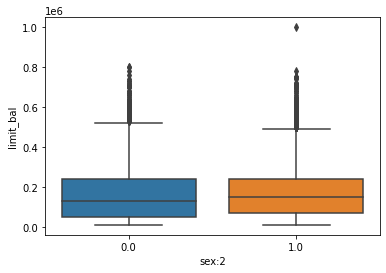

In [5]:
# BoxPlot for the gender feature
sns.boxplot(x='sex:2', y='limit_bal', data=df)
plt.show()

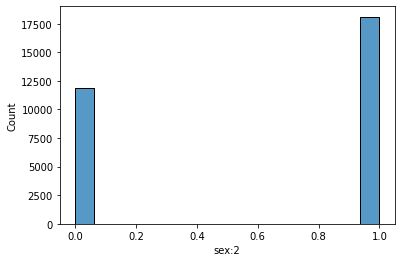

In [6]:
# Histogram of genders
sns.histplot(x='sex:2', data=df)
plt.show()

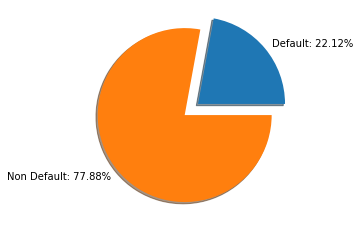

In [7]:
# Pie before upsampling

pie = np.array([sum(df['label']), len(df['label'])-sum(df['label'])])
mylabels = ["Default: {:.2f}%".format(sum(df['label'])/len(df['label'])*100), "Non Default: {:.2f}%".format((len(df['label'])-sum(df['label']))/len(df['label'])*100)]
myexplode = [0.2,0.0]

plt.pie(pie, labels = mylabels, explode = myexplode, shadow = True)
plt.show() 

This is an imbalanced dataset, consisting of 78% Non Default cases and 22% Default cases

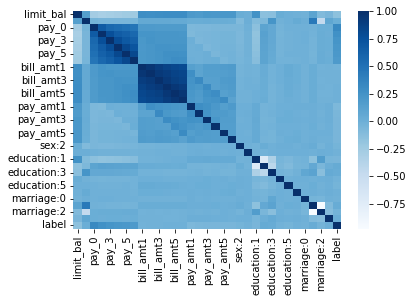

In [8]:
# Correlation Matrix
corr_matrix = df.corr()

sns.heatmap(corr_matrix, cmap="Blues")

plt.show()

In [12]:
# Separate feature columns (X) from label column (y)
X1 = df.drop('label', axis=1)
y1 = df['label']

scaler = MinMaxScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns) #scaling our data to between 0 and 1 

# StratifiedShuffleSplit 
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Split data in order to preserve the ratios between labels in the training and test data
for train_index, test_index in sss.split(X1, y1):
    X= X1.loc[train_index,:] 
    x = X1.loc[test_index,:]
    Y= y1.loc[train_index] 
    y = y1.loc[test_index]
    print('Class Ratio of training dataset: {:.3f}%'.format(sum(Y)/len(Y)))
    print('Class Ratio of test dataset: {:.3f}%'.format(sum(y)/len(y)) )

Class Ratio of training dataset: 0.221%
Class Ratio of test dataset: 0.221%


In [13]:
# SMOTE Upsampling 
smote = SMOTE()
X, Y = smote.fit_resample(X, Y) # we are only upsampling the training dataset



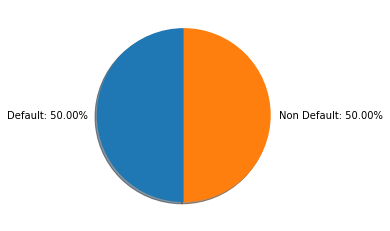

In [14]:
# Pie After Upsampling the training dataset
pieAfter = np.array([sum(Y), len(Y)-sum(Y)])
mylabels = ["Default: {:.2f}%".format(sum(Y)/len(Y)*100), "Non Default: {:.2f}%".format((len(Y)-sum(Y))/len(Y)*100)]

plt.pie(pieAfter, labels = mylabels, shadow = True,startangle=90)
plt.show() 

In [38]:
# Ratio of Labels after Upsampling with SMOTE

print('Class Ratio of training dataset After UpSampling: {:.3f}%'.format(sum(Y)/len(Y)))
print('Class Ratio of test dataset After UpSampling: {:.3f}%'.format(sum(y)/len(y)))

Class Ratio of training dataset After UpSampling: 0.500%
Class Ratio of test dataset After UpSampling: 0.221%


Predictive Models

In [16]:
# Decision Trees

DecTr = DecisionTreeClassifier(max_depth=5)

DecTr.fit(X, Y)
y_prDT = DecTr.predict(x)

precision = precision_score(y, y_prDT)
recall = recall_score(y, y_prDT)
f1 = f1_score(y, y_prDT)
accuracy = accuracy_score(y, y_prDT)
roc_auc = roc_auc_score(y, DecTr.predict_proba(x)[:, 1])

print("Decision Trees")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))

Decision Trees
Precision: 0.49
Recall: 0.51
F1 Score: 0.50
Accuracy: 0.78
ROC AUC Score: 0.75


In [17]:
# GaussianNB

Naive = GaussianNB()

Naive.fit(X, Y)
y_prNaive = Naive.predict(x)

precision = precision_score(y, y_prNaive)
recall = recall_score(y, y_prNaive)
f1 = f1_score(y, y_prNaive)
accuracy = accuracy_score(y, y_prNaive)
roc_auc = roc_auc_score(y, Naive.predict_proba(x)[:, 1])

print("GaussianNB")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))

GaussianNB
Precision: 0.23
Recall: 0.95
F1 Score: 0.38
Accuracy: 0.30
ROC AUC Score: 0.72


In [33]:
# MLP

mlp = MLPClassifier(hidden_layer_sizes=15)

mlp.fit(X, Y)
y_pred_mlp = mlp.predict(x)

precision = precision_score(y, y_pred_mlp)
recall = recall_score(y, y_pred_mlp)
f1 = f1_score(y, y_pred_mlp)
accuracy = accuracy_score(y, y_pred_mlp)
roc_auc = roc_auc_score(y, mlp.predict_proba(x)[:, 1])

print("MLP")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))

MLP
Precision: 0.46
Recall: 0.61
F1 Score: 0.52
Accuracy: 0.76
ROC AUC Score: 0.76


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [19]:
# XGB

model = xgb.XGBClassifier(max_depth=5)

model.fit(X, Y)
y_xgb = model.predict(x)

precision = precision_score(y, y_xgb)
recall = recall_score(y, y_xgb)
f1 = f1_score(y, y_xgb)
accuracy = accuracy_score(y, y_xgb)
roc_auc = roc_auc_score(y, model.predict_proba(x)[:, 1])

print("XGB")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))

XGB
Precision: 0.62
Recall: 0.41
F1 Score: 0.49
Accuracy: 0.81
ROC AUC Score: 0.75


In [20]:
# SVC

svc = SVC(probability=True)

svc.fit(X, Y)
y_prSVM = svc.predict(x)

precision = precision_score(y, y_prSVM)
recall = recall_score(y, y_prSVM)
f1 = f1_score(y, y_prSVM)
accuracy = accuracy_score(y, y_prSVM)
roc_auc = roc_auc_score(y, svc.predict_proba(x)[:, 1])

print("SVC")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))

SVC
Precision: 0.49
Recall: 0.54
F1 Score: 0.52
Accuracy: 0.77
ROC AUC Score: 0.73


In [21]:
# Random Forest

rf = RandomForestClassifier(n_estimators=300, max_depth=5)

rf.fit(X, Y)
y_prRF = rf.predict(x)


precision = precision_score(y, y_prRF)
recall = recall_score(y, y_prRF)
f1 = f1_score(y, y_prRF)
accuracy = accuracy_score(y, y_prRF)
roc_auc = roc_auc_score(y, rf.predict_proba(x)[:, 1])

print("Random Forest")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))



Random Forest
Precision: 0.51
Recall: 0.55
F1 Score: 0.53
Accuracy: 0.78
ROC AUC Score: 0.76


In [22]:
# Shap
explainer = shap.Explainer(rf.predict, x)

shap_values = explainer(x)

Permutation explainer: 6001it [1:06:25,  1.50it/s]                          


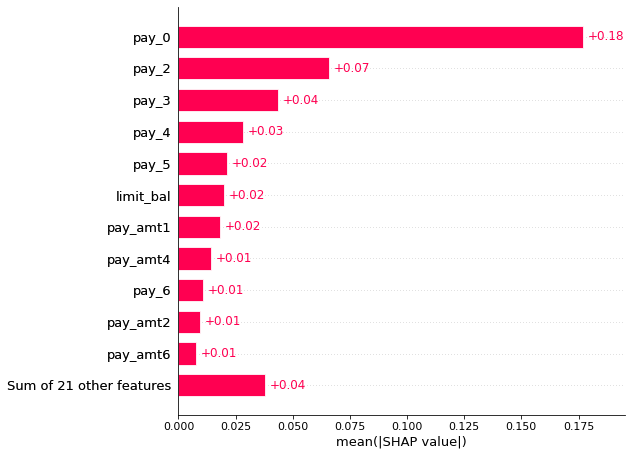

In [23]:
shap.plots.bar(shap_values, max_display=12)

The features in the Figure above are sorted in absolute values from the highest to the lowest effect on the prediction, so it does not take into account whether the feature affects the prediction in a positive or negative way.

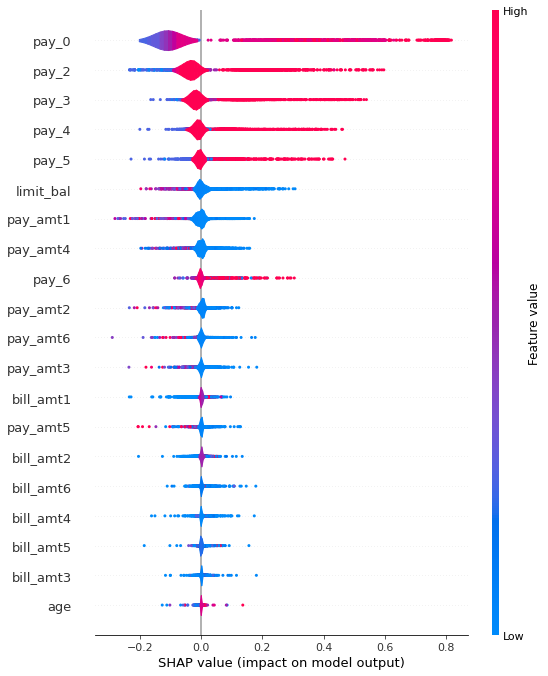

In [24]:
shap.summary_plot(shap_values, plot_type='violin')

On the Figure above, the features are also sorted by their effect on the prediction, but we can also see how higher and lower values of the feature will affect the result. All the dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations.

In [32]:
# KNN

knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X, Y) 

y_prKNN = knn.predict(x) # Make predictions on the test set

precision = precision_score(y, y_prKNN)
recall = recall_score(y, y_prKNN)
f1 = f1_score(y, y_prKNN)
accuracy = accuracy_score(y, y_prKNN)
roc_auc = roc_auc_score(y, knn.predict_proba(x)[:, 1])

print("KNN")
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))
print("Accuracy: {:.2f}".format(accuracy))
print("ROC AUC Score: {:.2f}".format(roc_auc))


KNN
Precision: 0.35
Recall: 0.61
F1 Score: 0.44
Accuracy: 0.66
ROC AUC Score: 0.69


In [28]:
# Fucntions to calculate recall, precision and f1 score

from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


Neural Network

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, DepthwiseConv1D,ConvLSTM1D, Dense, Concatenate , Dropout, Add, ReLU, BatchNormalization,AvgPool2D, MaxPool2D, GlobalAveragePooling2D, Reshape, Permute, Lambda, Flatten, Activation
import keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
from keras.optimizers import Adam
import keras
filters=64
def se_block(in_block, ch, ratio=16):
    x = layers.GlobalAveragePooling1D()(in_block)
    x = layers.Dense(ch//ratio, activation='relu')(x)
    x = layers.Dense(ch, activation='sigmoid')(x)
    return layers.Multiply()([in_block, x])

input = keras.Input(shape=(32, 1), name='board')
z = layers.Conv1D(filters, 3, activation='swish', kernel_regularizer=regularizers.l2(0.0001), padding='same')(input)
z = BatchNormalization()(z)
z = tf.keras.activations.swish(z)
for i in range (3):

    z1 = layers.Conv1D(filters+32, 1, activation='swish', kernel_regularizer=regularizers.l2(0.0001), padding='same')(z)
    z1 = Dropout(0.5)(z1)
    z1 = BatchNormalization()(z1)
    z1 = layers.DepthwiseConv1D(3, padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(z1)
    z1 = BatchNormalization()(z1)
    z1 = Dropout(0.2)(z1)
    z1 = layers.Conv1D(filters, 1, activation='swish', kernel_regularizer=regularizers.l2(0.0001), padding='same')(z1)
    z1 = BatchNormalization()(z1)
    z1 = se_block(z1, filters, 8)

    z = layers.add([z1, z])
    z = BatchNormalization()(z)
    z = tf.keras.activations.swish(z)

for i in range (2):

    kk = layers.Conv1D(filters+32, 1, activation='swish', kernel_regularizer=regularizers.l2(0.0001), padding='same')(z)
    kk = Dropout(0.2)(kk)
    kk = BatchNormalization()(kk)
    kk = layers.DepthwiseConv1D(5, padding='same', kernel_regularizer=regularizers.l2(0.0001), use_bias = False)(kk)
    kk = BatchNormalization()(kk)
    kk = Dropout(0.2)(kk)
    kk = layers.Conv1D(filters, 1, activation='swish', kernel_regularizer=regularizers.l2(0.0001), padding='same')(kk)
    kk = BatchNormalization()(kk)
    kk = se_block(kk, filters, 8)

    z = layers.add([kk, z])
    z = BatchNormalization()(z)
    z = tf.keras.activations.swish(z)

final = layers.MaxPooling1D(pool_size=2)(z)
final = layers.Flatten()(final)

final = layers.Dense(16, activation='swish', kernel_regularizer=regularizers.l2(0.0001))(final)
final = layers.Dense(1, activation='sigmoid', name='value', kernel_regularizer=regularizers.l2(0.0001))(final)

model = keras.Model(inputs=input, outputs= final)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board (InputLayer)             [(None, 32, 1)]      0           []                               
                                                                                                  
 conv1d_49 (Conv1D)             (None, 32, 64)       256         ['board[0][0]']                  
                                                                                                  
 batch_normalization_93 (BatchN  (None, 32, 64)      256         ['conv1d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.nn.silu_27 (TFOpLambda)     (None, 32, 64)       0           ['batch_normalization_93[0]

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',f1_m,precision_m, recall_m,tf.keras.metrics.AUC()])

model.fit(X, Y, epochs=200, batch_size=32, validation_data=(x,y), verbose=1)

Epoch 1/200
1169/1169 [==============================] - 43s 30ms/step - loss: 0.6999 - accuracy: 0.6503 - f1_m: 0.6050 - precision_m: 0.7086 - recall_m: 0.5541 - auc_3: 0.6982 - val_loss: 0.7622 - val_accuracy: 0.7247 - val_f1_m: 0.4975 - val_precision_m: 0.4204 - val_recall_m: 0.6522 - val_auc_3: 0.7437
Epoch 2/200
1169/1169 [==============================] - 40s 34ms/step - loss: 0.6534 - accuracy: 0.6877 - f1_m: 0.6453 - precision_m: 0.7373 - recall_m: 0.5874 - auc_3: 0.7417 - val_loss: 0.7280 - val_accuracy: 0.6670 - val_f1_m: 0.4772 - val_precision_m: 0.3711 - val_recall_m: 0.7177 - val_auc_3: 0.7584
Epoch 3/200
1169/1169 [==============================] - 33s 28ms/step - loss: 0.6313 - accuracy: 0.6912 - f1_m: 0.6531 - precision_m: 0.7371 - recall_m: 0.6005 - auc_3: 0.7519 - val_loss: 0.6383 - val_accuracy: 0.7410 - val_f1_m: 0.5022 - val_precision_m: 0.4384 - val_recall_m: 0.6251 - val_auc_3: 0.7630
Epoch 4/200
1169/1169 [==============================] - 32s 28ms/step - loss: 

KeyboardInterrupt: ignored

In [ ]:
resultsDL= model.evaluate(x,y)

188/188 [==============================] - 1s 7ms/step - loss: 0.5943 - accuracy: 0.7337 - f1_m: 0.5020 - precision_m: 0.4328 - recall_m: 0.6381 - auc_3: 0.7611
